$$\textbf{Contextual Newsvendor}$$

We are selling orange juice on the street. It is well known that the daily demand is highly sensitive to the peak temperature of the day, and therefore we want to utilize the weather forecast to determine the order quantity (# of oranges to prepare).

 To identify this relationship, we collected observations for past $n$ days, and obtained a dataset $\{ (x_i, D_i) \}_{i=1}^n$ where $x_i$ is the forecasted temperature of day $i$, and $D_i$ is the (uncensored) demand of day $i$. This dataset is given in `sales.csv`, which is visualized below.

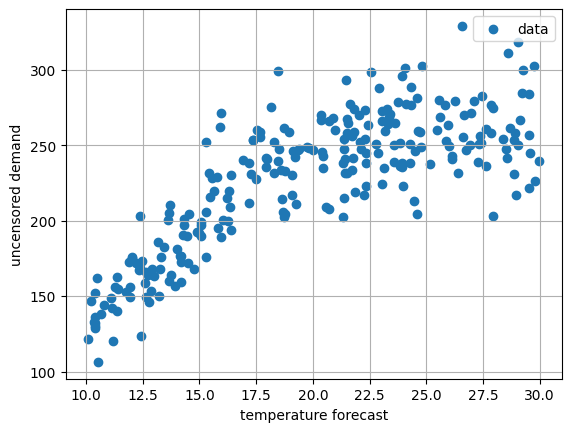

In [ ]:
data = pd.read_csv( 'sales.csv' )
pyplot.scatter( data.x, data.D, label='data' )
pyplot.xlabel( "temperature forecast" )
pyplot.ylabel( "uncensored demand" )
pyplot.grid( True )
pyplot.legend( loc='best' )

Throughout this problem, we will restrict our attention to the log-linear model:
$$ D_i = \exp\left( \theta_b + \theta_m x_i + \epsilon_i \right), $$
where $(\theta_b, \theta_m) \in \mathbb{R}^2$ are the unknown model parameters to be estimated from the data, and $\epsilon_i$ is the unpredictable noise.
We assume that $\epsilon_i \sim \mathcal{N}(0, 0.1^2)$, indepedent of $x_i$.

If the parameters $(\theta_b, \theta_m)$ are known, the optimal ordering rule $q^\star(x)$ as a function of temperature forecast $x$ will be defined by
$$ q^\star(x; \theta_b, \theta_m) := \arg\min_{q \in \mathbb{R}} \mathbb{E}\left[ \left. \mathcal{L}(q,D) \right| x \right], \quad \mathcal{L}(q,D) := c (q-D)^+ + (p-c) (D-q)^+, $$
where $c$ is the order cost and $p$ is the sales price. It is not difficult to show that $q^\star(x)$ under the log-linear model above can be expressed as
$$ q^\star(x; \theta_b, \theta_m) = \exp\left( \theta_b + \theta_m x +  0.1 \times \Phi^{-1}\left( \frac{p-c}{p} \right) \right), $$
where $\Phi(\cdot)$ the cdf of standard normal distribution. We assume that $c=1$ and $p=5$, and then $q^\star(x; \theta_a, \theta_b)$ can be implemented as follows:

In [ ]:
order_cost, sales_price = 1.0, 5.0
offset = 0.1*scipy.stats.norm.ppf( (sales_price-order_cost)/sales_price )

def optimal_order_quantity( temperature_forecast, theta_b, theta_m ):
  return np.exp( theta_b + theta_m*temperature_forecast + offset )

$$ \textbf{Predict-then-optimize with MLE}$$

We first consider a naive "estimate-then-optimize" approach. **Complete the function `MLE()`** that estimates the parameters $(\theta_b, \theta_m)$ using maximum likelihood estimation, i.e.,
$$ (\hat{\theta}_b, \hat{\theta}_m) \gets \arg\min_{(\theta_b, \theta_m)} \sum_{i=1}^n \left( \log(D_i) - (\theta_b + \theta_m x_i) \right)^2. $$




In [ ]:
def MLE( temperature_forecasts, uncensored_demands ):
  x=np.array(temperature_forecasts)
  y=np.log(np.array(uncensored_demands))
  def loss(parameter):
    theta_b,theta_m=parameter
    return np.sum((y-theta_b-theta_m*x)**2)

  guess=[4.0,0.05]
  theta_b,theta_m=scipy.optimize.minimize(loss,guess).x
  return (theta_b, theta_m)

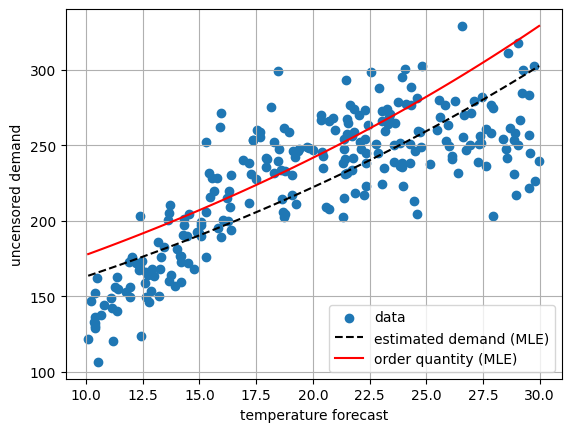

In [ ]:
data = pd.read_csv( 'sales.csv' )
pyplot.scatter( data.x, data.D, label='data' )
pyplot.xlabel( "temperature forecast" )
pyplot.ylabel( "uncensored demand" )
pyplot.grid( True )

MLE_theta_b, MLE_theta_m = MLE( list(data.x), list(data.D) )

xs = np.linspace( data.x.min(), data.x.max(), 100 )
pyplot.plot( xs, np.exp( MLE_theta_b + MLE_theta_m*xs ), '--', c='k', label='estimated demand (MLE)' )
pyplot.plot( xs, optimal_order_quantity( xs, MLE_theta_b, MLE_theta_m ), '-', c='r', label='order quantity (MLE)' )
pyplot.legend( loc='best' )

$$\textbf{Decision-focused Learning}$$

We now consider the decision-aware learning approach (DFL) that estimates the parameters $(\theta_b, \theta_m)$ by solving the following minimization problem:
$$ (\hat{\theta}_b, \hat{\theta}_m) \gets \arg\min_{(\theta_b, \theta_m)} \sum_{i=1}^n \mathcal{L}\left( q^\star(x_i; \theta_b, \theta_m), D_i \right). $$



In [ ]:
def DFL( temperature_forecasts, uncensored_demands ):
  x=np.array(temperature_forecasts)
  y=np.array(uncensored_demands)
  def loss(parameter):
    theta_b,theta_m=parameter
    loss=0
    for i in range(len(x)):
      q=optimal_order_quantity(x[i],theta_b,theta_m)
      loss+=max(q-y[i],0)+0.5*max(y[i]-q,0) #adjsting for the given values of c and p
    return loss

  guess=[4.0,0.05]
  theta_b,theta_m=scipy.optimize.minimize(loss,guess).x
  return (theta_b, theta_m)


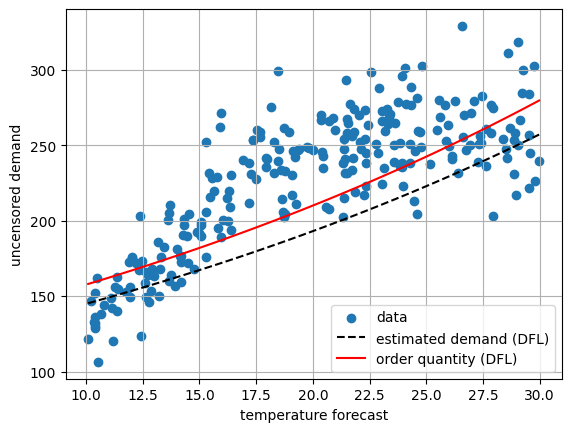

In [ ]:
data = pd.read_csv( 'sales.csv' )
pyplot.scatter( data.x, data.D, label='data' )
pyplot.xlabel( "temperature forecast" )
pyplot.ylabel( "uncensored demand" )
pyplot.grid( True )

DFL_theta_b, DFL_theta_m = DFL( list(data.x), list(data.D) )

xs = np.linspace( data.x.min(), data.x.max(), 100 )
pyplot.plot( xs, np.exp( DFL_theta_b + DFL_theta_m*xs ), '--', c='k', label='estimated demand (DFL)' )
pyplot.plot( xs, optimal_order_quantity( xs, DFL_theta_b, DFL_theta_m ), '-', c='r', label='order quantity (DFL)' )
pyplot.legend( loc='best' )